## Попытка № 1. Константный прогноз и стандартный SVC.

In [23]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier 
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score

from sklearn.svm import SVC  
from tqdm import tqdm

import nltk

np.random.seed(42)
random.seed(42)

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [7]:
X_train = df_train.text_lemmatized
X_test = df_test.text_lemmatized

y_train = df_train.label
y_test = df_test.label

Сделаем константный прогноз, чтобы оценить потом свои модели относительно простейшей.

In [8]:
%%time
# Сначала закодируем слова в векторы
vec = TfidfVectorizer(ngram_range=(1, 2)) # используем уни-, биграммы
vec_fit = vec.fit(X_train)

svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

CPU times: total: 13.1 s
Wall time: 13.1 s


In [16]:
vec_fit = vec.fit(X_train)

In [17]:
vec_train = vec_fit.transform(X_train)

In [18]:
vec_test = vec_fit.transform(X_test)

In [19]:
dc_mf = DummyClassifier(strategy="most_frequent") 
dc_mf.fit(vec_train, y_train) 

DummyClassifier(strategy='most_frequent')

In [20]:
y_pred_dc = dc_mf.predict(vec_test) 

In [21]:
y_pred_train_dc = dc_mf.predict(vec_train) 

In [22]:
f1_score(y_train, y_pred_train_dc, average='micro')

0.5079387296094643

In [23]:
f1_score(y_test, y_pred_dc, average='micro')

0.5083430052906863

In [24]:
recall_score(y_test, y_pred_dc, average='micro')

0.5083430052906863

In [25]:
precision_score(y_test, y_pred_dc, average='micro')

0.5083430052906863

In [24]:
# Прогноз самым часто встречающимся классом
confusion_matrix(y_test, y_pred_dc)

array([[     0,      0,  37285],
       [     0,      0, 158423],
       [     0,      0, 202350]], dtype=int64)

In [25]:
# Обучимся частями по всей выборке (внимание на время)
ran = np.arange(y_train.shape[0])
inds = np.array_split(ran, 10) 
inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=1000))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
    svm.fit(vec_train[chunk, :], y_train.iloc[chunk])

100%|██████████| 10/10 [7:28:54<00:00, 2693.46s/it] 


In [26]:
# Спойлер: лучшие метрики за все эксперименты
svm_pred1 = svm.predict(vec_test)

print(confusion_matrix(y_test,svm_pred1))
print(classification_report(y_test,svm_pred1))

f1_score(y_test, svm_pred1, average='micro')

[[  3130  17948  16207]
 [  1897  68512  88014]
 [   854  43969 157527]]
              precision    recall  f1-score   support

           0       0.53      0.08      0.15     37285
           1       0.53      0.43      0.47    158423
           2       0.60      0.78      0.68    202350

    accuracy                           0.58    398058
   macro avg       0.55      0.43      0.43    398058
weighted avg       0.56      0.58      0.55    398058



0.5757176089916545

In [29]:
# На трейне скор также невысокий, переобучения нет
f1_score(y_train, svm.predict(vec_train), average='micro')

0.604514853020184

In [27]:
cf_matrix = confusion_matrix(y_test,svm_pred1)

<AxesSubplot: >

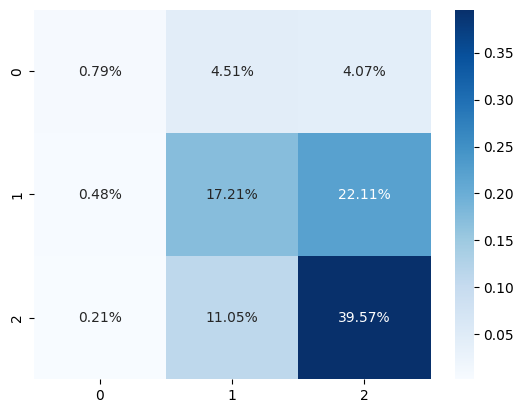

In [28]:
# confusion matrix с процентным соотношением классов
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')